In [1]:
import monai

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONFIG_PATH = "./10441/copick.config"
RESOLUTION = 2
SESSION_ID = "0"
TOMO_TYPE = "wbp" 
USER_ID = "curation"
VOXEL_SIZE =  10
VOXEL_SPACING = VOXEL_SIZE *  (2**RESOLUTION)
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",
    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "identifier": "GO:0070288",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-amylase",
            "identifier": "UniProtKB:P10537",
            "is_particle": true,
            "pdb_id": "1FA2",
            "label": 2,
            "color": [153,  63,   0, 128],
            "radius": 65,
            "map_threshold": 0.035
        },
        {
            "name": "beta-galactosidase",
            "identifier": "UniProtKB:P00722",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "identifier": "GO:0022626",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "identifier": "UniProtKB:P01267",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "identifier": "GO:0170047",
            "is_particle": true,
            "pdb_id": "6N4V",            
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        }
    ],
    "overlay_root": "./10441/overlay/",
    "static_root": "./10441/",
    "overlay_fs_args": {
        "auto_mkdir": true
    }
}"""
with open(CONFIG_PATH, "w") as f:
    f.write(config_blob)


In [3]:
import copick
import numpy as np
from tqdm import tqdm

root = copick.from_file(CONFIG_PATH)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = VOXEL_SIZE

In [4]:
print(f"Number of runs: {len(root.runs)}")

Number of runs: 27


In [5]:
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

# Just do this once
generate_masks = True
if generate_masks:
    target_objects = defaultdict(dict)
    for object in root.pickable_objects:
        if object.is_particle:
            target_objects[object.name]['label'] = object.label
            target_objects[object.name]['radius'] = object.radius


    for run in tqdm(root.runs):
        tomo = run.get_voxel_spacing(voxel_size)
        tomo = tomo.get_tomogram(TOMO_TYPE).numpy()
        target = np.zeros(tomo.shape, dtype=np.uint8)
        for pickable_object in root.pickable_objects:
            pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
            if len(pick):  
                target = segmentation_from_picks.from_picks(pick[0], 
                                                            target, 
                                                            target_objects[pickable_object.name]['radius'] * 0.8,
                                                            target_objects[pickable_object.name]['label']
                                                            )
        write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


In [6]:

from pathlib import Path
import numpy as np

tomo_type_list = ["wbp"]
# Define directories for saving numpy arrays
train_image_dir = Path('./datasets/exdata/images')
train_label_dir = Path('./datasets/exdata/labels')
val_image_dir = Path('./datasets/val/images')
val_label_dir = Path('./datasets/val/labels')

for dir_path in [train_image_dir, train_label_dir, val_image_dir, val_label_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

# root.runs의 개수 출력
print(f"Number of runs: {len(root.runs)}")

for tomo_type in tomo_type_list:
    print(f"Processing \"{tomo_type}\" data...")
    for vol_idx, run in enumerate(root.runs):
        # Load image and label data
        tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
        segmentation = run.get_segmentations(
            name=copick_segmentation_name,
            user_id=copick_user_name,
            voxel_size=voxel_size,
            is_multilabel=True
        )[0].numpy()

        # Format run name
        run_name = run.name.replace("\\", "_").replace("/", "_")

        # Determine if this is the last volume
        # is_val_volume = True if vol_idx >= (len(root.runs) - 3) else False
        is_val_volume = False

        # Set directories based on whether it's the last volume
        image_dir = val_image_dir if is_val_volume else train_image_dir
        label_dir = val_label_dir if is_val_volume else train_label_dir

        # Save tomogram and segmentation as numpy arrays
        image_path = image_dir / f"{tomo_type}_{run_name}.npy"
        label_path = label_dir / f"{tomo_type}_{run_name}.npy"
        np.save(image_path, tomogram)
        np.save(label_path, segmentation)

        # 저장된 파일 경로 출력
        print(f"Saved image: {image_path}")
        print(f"Saved label: {label_path}")

# 저장된 파일의 개수 출력
print(f"Number of files in train images: {len(list(train_image_dir.glob('*.npy')))}")
print(f"Number of files in train labels: {len(list(train_label_dir.glob('*.npy')))}")
print(f"Number of files in val images: {len(list(val_image_dir.glob('*.npy')))}")
print(f"Number of files in val labels: {len(list(val_label_dir.glob('*.npy')))}")

print("Processing complete.")

Number of runs: 27
Processing "wbp" data...
Saved image: datasets\exdata\images\wbp_TS_0.npy
Saved label: datasets\exdata\labels\wbp_TS_0.npy
Saved image: datasets\exdata\images\wbp_TS_1.npy
Saved label: datasets\exdata\labels\wbp_TS_1.npy
Saved image: datasets\exdata\images\wbp_TS_10.npy
Saved label: datasets\exdata\labels\wbp_TS_10.npy
Saved image: datasets\exdata\images\wbp_TS_11.npy
Saved label: datasets\exdata\labels\wbp_TS_11.npy
Saved image: datasets\exdata\images\wbp_TS_12.npy
Saved label: datasets\exdata\labels\wbp_TS_12.npy
Saved image: datasets\exdata\images\wbp_TS_13.npy
Saved label: datasets\exdata\labels\wbp_TS_13.npy
Saved image: datasets\exdata\images\wbp_TS_14.npy
Saved label: datasets\exdata\labels\wbp_TS_14.npy
Saved image: datasets\exdata\images\wbp_TS_15.npy
Saved label: datasets\exdata\labels\wbp_TS_15.npy
Saved image: datasets\exdata\images\wbp_TS_16.npy
Saved label: datasets\exdata\labels\wbp_TS_16.npy
Saved image: datasets\exdata\images\wbp_TS_17.npy
Saved labe

In [8]:
import os
from pathlib import Path
import numpy as np


# Define the directory containing the .npy files
train_label_dir = Path('./datasets/exdata/labels')
augment_list = ['ctfdeconvolved', 'denoised', 'isonetcorrected']
# Define the desired naming convention
def get_new_filename(old_filename, augment):
    # Example: Add a prefix "new_" to the original filename
    return old_filename.replace("wbp", augment)

# Iterate over all .npy files in the directory
for npy_file in train_label_dir.glob('*.npy'):
    # Load the .npy file
    data = np.load(npy_file)
    
    # Get the new filename
    for augment in augment_list:
        new_filename = get_new_filename(npy_file.name, augment)
        
        # Define the new file path
        new_file_path = train_label_dir / new_filename
        
        # Save the data with the new filename
        np.save(new_file_path, data)
        
        # Optionally, remove the old file
        # os.remove(npy_file)
        
        print(f"Saved {npy_file} to {new_file_path}")

Saved datasets\exdata\labels\wbp_TS_0.npy to datasets\exdata\labels\ctfdeconvolved_TS_0.npy
Saved datasets\exdata\labels\wbp_TS_0.npy to datasets\exdata\labels\denoised_TS_0.npy
Saved datasets\exdata\labels\wbp_TS_0.npy to datasets\exdata\labels\isonetcorrected_TS_0.npy
Saved datasets\exdata\labels\wbp_TS_1.npy to datasets\exdata\labels\ctfdeconvolved_TS_1.npy
Saved datasets\exdata\labels\wbp_TS_1.npy to datasets\exdata\labels\denoised_TS_1.npy
Saved datasets\exdata\labels\wbp_TS_1.npy to datasets\exdata\labels\isonetcorrected_TS_1.npy
Saved datasets\exdata\labels\wbp_TS_10.npy to datasets\exdata\labels\ctfdeconvolved_TS_10.npy
Saved datasets\exdata\labels\wbp_TS_10.npy to datasets\exdata\labels\denoised_TS_10.npy
Saved datasets\exdata\labels\wbp_TS_10.npy to datasets\exdata\labels\isonetcorrected_TS_10.npy
Saved datasets\exdata\labels\wbp_TS_11.npy to datasets\exdata\labels\ctfdeconvolved_TS_11.npy
Saved datasets\exdata\labels\wbp_TS_11.npy to datasets\exdata\labels\denoised_TS_11.npy

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.ndimage as ndi
# from skimage.metrics import structural_similarity as ssim

# def gaussian_smooth_image(image, sigma=1.0):
#     """3D 가우시안 스무딩"""
#     return ndi.gaussian_filter(image, sigma=(sigma, sigma, sigma))

# def mse(imageA, imageB):
#     """Mean Squared Error"""
#     return np.mean((imageA - imageB) ** 2)

# def linear_adjust_to_ref(source, ref):
#     """source 영상을 ref 영상의 mean, std에 맞춰 재조정."""
#     mean_s = source.mean()
#     std_s  = source.std()
#     mean_r = ref.mean()
#     std_r  = ref.std() if ref.std() != 0 else 1e-8

#     # (x - mean_s)/std_s -> 스케일링 -> *std_r + mean_r
#     normalized = (source - mean_s) / (std_s + 1e-8)
#     return normalized * std_r + mean_r

# # 이미지와 라벨 불러오기
# image1 = np.load("datasets/train/images/wbp_TS_5_4.npy")
# label1 = np.load("datasets/train/labels/wbp_TS_5_4.npy")
# image2 = np.load("datasets/train/images/denoised_TS_5_4.npy")
# label2 = np.load("datasets/train/labels/denoised_TS_5_4.npy")

# # 다양한 필터 적용
# sigma = 3.0
# image1_gauss1  = gaussian_smooth_image(image1, sigma=1.0)
# image1_gauss2  = gaussian_smooth_image(image1, sigma=2.0)
# image1_gauss3  = gaussian_smooth_image(image1, sigma=3.0)

# image2_gauss  = gaussian_smooth_image(image2, sigma=2.0)

# image1_gauss_adj = linear_adjust_to_ref(image1_gauss2, image2)

# # MSE, SSIM 비교 함수
# def compare_images(ref, target, label=""):
#     """ref와 target을 비교하여 MSE, SSIM을 출력."""
#     # MSE
#     score_mse = mse(ref, target)
#     # SSIM
#     # 데이터 범위를 설정하기 위해 data_range를 직접 지정(예: ref.max() - ref.min())
#     score_ssim, diff = ssim(ref, target, data_range=ref.max() - ref.min(), full=True)
#     print(f"{label} -> MSE: {score_mse:.4f}, SSIM: {score_ssim:.4f}")
#     return score_mse, score_ssim

# # image1_* vs image2
# compare_images(image2, image1,        label="image1 Original vs image2")
# compare_images(image2, image1_gauss1,  label="image1 Gaussian1 vs image2")
# compare_images(image2, image1_gauss2,  label="image1 Gaussian2 vs image2")
# compare_images(image2, image1_gauss3,  label="image1 Gaussian3 vs image2")
# compare_images(image2, image1_gauss_adj, label="image1 Gaussian2 Adjusted vs image2")

# # 시각화
# slice_idx = 100

# plt.figure(figsize=(20, 5))

# # Image 1 비교
# plt.subplot(1, 7, 1)
# plt.imshow(image1[slice_idx], cmap="gray")
# plt.title("Image1: Original")
# plt.axis("off")

# plt.subplot(1, 7, 2)
# plt.imshow(image1_gauss1[slice_idx], cmap="gray")
# plt.title("Image1: Gaussian1")
# plt.axis("off")

# # Image 2 비교
# plt.subplot(1, 7, 3)
# plt.imshow(image1_gauss2[slice_idx], cmap="gray")
# plt.title("Image1: Gaussian2")
# plt.axis("off")

# plt.subplot(1, 7, 4)
# plt.imshow(image1_gauss3[slice_idx], cmap="gray")
# plt.title("Image1: Gaussian3")
# plt.axis("off")

# plt.subplot(1, 7, 5)
# plt.imshow(image1_gauss_adj[slice_idx], cmap="gray")
# plt.title("Image1: Gaussian2+adjusted")
# plt.axis("off")

# plt.subplot(1, 7, 6)
# plt.imshow(image2[slice_idx], cmap="gray")
# plt.title("Image2: Denoised")
# plt.axis("off")

# plt.subplot(1, 7, 7)
# plt.imshow(image2_gauss[slice_idx], cmap="gray")
# plt.title("Image2: Denoised+Gaussian")
# plt.axis("off")

# plt.tight_layout()
# plt.show()

In [1]:
# Make a copick project
import os
import shutil

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
output_overlay = "./kaggle/working/overlay"


with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = './kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = './kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\apo-ferritin.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_apo-ferritin.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\beta-amylase.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_beta-amylase.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\beta-galactosidase.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_beta-galactosidase.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\ribosome.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_ribosome.json
Copied ./kaggle/input/czii-cryo-et-object-identification/train/overlay\ExperimentRuns\TS_5_4\Picks\thyroglobulin.json to ./kaggle/working/overlay\ExperimentRuns\TS_5_4\Picks\curation_0_thy

In [2]:
import copick
import numpy as np
from tqdm import tqdm

root = copick.from_file(copick_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10

In [3]:
len(root.runs)

7

In [4]:
from copick_utils.segmentation import segmentation_from_picks
import copick_utils.writers.write as write
from collections import defaultdict

# Just do this once
generate_masks = True
tomo_type_list = ["ctfdeconvolved", "denoised", "isonetcorrected", "wbp"]
# tomo_type_list = ["wbp", "denoised"]
for tomo_type in tomo_type_list:

    if generate_masks:
        target_objects = defaultdict(dict)
        for object in root.pickable_objects:
            if object.is_particle:
                target_objects[object.name]['label'] = object.label
                target_objects[object.name]['radius'] = object.radius


        for run in tqdm(root.runs):
            tomo = run.get_voxel_spacing(10)
            tomo = tomo.get_tomogram(tomo_type).numpy()
            target = np.zeros(tomo.shape, dtype=np.uint8)
            for pickable_object in root.pickable_objects:
                pick = run.get_picks(object_name=pickable_object.name, user_id="curation")
                if len(pick):  
                    target = segmentation_from_picks.from_picks(pick[0], 
                                                                target, 
                                                                target_objects[pickable_object.name]['radius'] * 0.8,
                                                                target_objects[pickable_object.name]['label']
                                                                )
            write.segmentation(run, target, copick_user_name, name=copick_segmentation_name)

100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


In [ ]:
from pathlib import Path
import numpy as np

# tomo_type_list = ["wbp"]
# Define directories for saving numpy arrays
train_image_dir = Path('./datasets/train/images')
train_label_dir = Path('./datasets/train/labels')
val_image_dir = Path('./datasets/val/images')
val_label_dir = Path('./datasets/val/labels')

for dir_path in [train_image_dir, train_label_dir, val_image_dir, val_label_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

# root.runs의 개수 출력
print(f"Number of runs: {len(root.runs)}")

for tomo_type in tomo_type_list:
    print(f"Processing \"{tomo_type}\" data...")
    for vol_idx, run in enumerate(root.runs):
        # Load image and label data
        tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
        segmentation = run.get_segmentations(
            name=copick_segmentation_name,
            user_id=copick_user_name,
            voxel_size=voxel_size,
            is_multilabel=True
        )[0].numpy()

        # Format run name
        run_name = run.name.replace("\\", "_").replace("/", "_")

        # Determine if this is the last volume
        # is_last_volume = (vol_idx == len(root.runs) - 1)\
        is_last_volume = False
        if vol_idx == len(root.runs) - 1:
            if tomo_type == "denoised":
                is_last_volume = True
            else:
                continue
            
        # Set directories based on whether it's the last volume
        image_dir = val_image_dir if is_last_volume else train_image_dir
        label_dir = val_label_dir if is_last_volume else train_label_dir

        # Save tomogram and segmentation as numpy arrays
        image_path = image_dir / f"{tomo_type}_{run_name}.npy"
        label_path = label_dir / f"{tomo_type}_{run_name}.npy"
        np.save(image_path, tomogram)
        np.save(label_path, segmentation)

        # 저장된 파일 경로 출력
        print(f"Saved image: {image_path}")
        print(f"Saved label: {label_path}")

# 저장된 파일의 개수 출력
print(f"Number of files in train images: {len(list(train_image_dir.glob('*.npy')))}")
print(f"Number of files in train labels: {len(list(train_label_dir.glob('*.npy')))}")
print(f"Number of files in val images: {len(list(val_image_dir.glob('*.npy')))}")
print(f"Number of files in val labels: {len(list(val_label_dir.glob('*.npy')))}")

print("Processing complete.")

Number of runs: 7
Processing "ctfdeconvolved" data...
Saved image: datasets\train\images\ctfdeconvolved_TS_5_4.npy
Saved label: datasets\train\labels\ctfdeconvolved_TS_5_4.npy
Saved image: datasets\train\images\ctfdeconvolved_TS_69_2.npy
Saved label: datasets\train\labels\ctfdeconvolved_TS_69_2.npy
Saved image: datasets\train\images\ctfdeconvolved_TS_6_4.npy
Saved label: datasets\train\labels\ctfdeconvolved_TS_6_4.npy
Saved image: datasets\train\images\ctfdeconvolved_TS_6_6.npy
Saved label: datasets\train\labels\ctfdeconvolved_TS_6_6.npy
Saved image: datasets\train\images\ctfdeconvolved_TS_73_6.npy
Saved label: datasets\train\labels\ctfdeconvolved_TS_73_6.npy
Saved image: datasets\train\images\ctfdeconvolved_TS_86_3.npy
Saved label: datasets\train\labels\ctfdeconvolved_TS_86_3.npy
Saved image: datasets\val\images\ctfdeconvolved_TS_99_9.npy
Saved label: datasets\val\labels\ctfdeconvolved_TS_99_9.npy
Processing "denoised" data...
Saved image: datasets\train\images\denoised_TS_5_4.npy
Sav

In [24]:
if

SyntaxError: invalid syntax (4110802630.py, line 1)

In [6]:
from pathlib import Path
import numpy as np

# tomo_type_list = ["wbp"]
# Define directories for saving numpy arrays
train_image_dir = Path('./datasets/aug_data/train/')
train_label_dir = Path('./datasets/aug_data/train/')
val_image_dir = Path('./datasets/aug_data/val/')
val_label_dir = Path('./datasets/aug_data/val/')

for dir_path in [train_image_dir, train_label_dir, val_image_dir, val_label_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

# root.runs의 개수 출력
print(f"Number of runs: {len(root.runs)}")

for tomo_type in tomo_type_list:
    print(f"Processing \"{tomo_type}\" data...")
    for vol_idx, run in enumerate(root.runs):
        # Load image and label data
        tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()
        segmentation = run.get_segmentations(
            name=copick_segmentation_name,
            user_id=copick_user_name,
            voxel_size=voxel_size,
            is_multilabel=True
        )[0].numpy()

        # Format run name
        run_name = run.name.replace("\\", "_").replace("/", "_")

        # Determine if this is the last volume
        is_last_volume = (vol_idx == len(root.runs) - 1)
        # Set directories based on whether it's the last volume
        image_dir = val_image_dir if is_last_volume else train_image_dir
        label_dir = val_label_dir if is_last_volume else train_label_dir

        image_dir = image_dir / f"{tomo_type}"
        label_dir = label_dir / f"{tomo_type}"
        
        image_dir.mkdir(parents=True, exist_ok=True)
        label_dir.mkdir(parents=True, exist_ok=True)
        
        # Save tomogram and segmentation as numpy arrays
        image_path = image_dir / f"{run_name}.npy"
        label_path = label_dir / f"{run_name}.npy"
        
        # 이미지를 0~255로 정규화
        tomogram = (tomogram - tomogram.min())/ (tomogram.max() - tomogram.min()) * 255
        tomogram = tomogram.astype(np.uint8)
        
        if vol_idx == len(root.runs) - 1:
            np.save(label_path, tomogram)
            print(f"Saved label: {label_path}")
        else:
            np.save(image_path, tomogram)
            print(f"Saved image: {image_path}")


# 저장된 파일의 개수 출력
print(f"Number of files in train images: {len(list(train_image_dir.glob('*.npy')))}")
print(f"Number of files in train labels: {len(list(train_label_dir.glob('*.npy')))}")
print(f"Number of files in val images: {len(list(val_image_dir.glob('*.npy')))}")
print(f"Number of files in val labels: {len(list(val_label_dir.glob('*.npy')))}")

print("Processing complete.")

Number of runs: 7
Processing "ctfdeconvolved" data...
Saved image: datasets\aug_data\train\ctfdeconvolved\TS_5_4.npy
Saved image: datasets\aug_data\train\ctfdeconvolved\TS_69_2.npy
Saved image: datasets\aug_data\train\ctfdeconvolved\TS_6_4.npy
Saved image: datasets\aug_data\train\ctfdeconvolved\TS_6_6.npy
Saved image: datasets\aug_data\train\ctfdeconvolved\TS_73_6.npy
Saved image: datasets\aug_data\train\ctfdeconvolved\TS_86_3.npy
Saved label: datasets\aug_data\val\ctfdeconvolved\TS_99_9.npy
Processing "denoised" data...
Saved image: datasets\aug_data\train\denoised\TS_5_4.npy
Saved image: datasets\aug_data\train\denoised\TS_69_2.npy
Saved image: datasets\aug_data\train\denoised\TS_6_4.npy
Saved image: datasets\aug_data\train\denoised\TS_6_6.npy
Saved image: datasets\aug_data\train\denoised\TS_73_6.npy
Saved image: datasets\aug_data\train\denoised\TS_86_3.npy
Saved label: datasets\aug_data\val\denoised\TS_99_9.npy
Processing "isonetcorrected" data...
Saved image: datasets\aug_data\trai

unique values in denoised image: 205
unique values in wbp image: 207
unique values in gaussian blur_image: 63
unique values in multi gaussian blur_image4: 63
Original image min: 0 max: 255
Label image min: 0 max: 255
Gaussian blur image min: 85 max: 152
Multi Gaussian blur image min: 85 max: 152
Original image min: 0 max: 255
Label image min: 0 max: 255
Gaussian blur image min: 85 max: 152
Multi Gaussian blur image min: 85 max: 152
unique values in gaussian blur_image: 63
unique values in multi gaussian blur_image4: 63
unique values in multi gaussian blur_image5: 26
Mean of image: 132.05060972537163, Standard Deviation of image: 6.7676636186533585
Mean of label: 173.00494079113128, Standard Deviation of label: 4.424722487140303
Mean of blur_image: 130.55180650037792, Standard Deviation of blur_image: 0.8117581284509229
Mean of blur_image4: 130.55178130511464, Standard Deviation of blur_image4: 0.8117535284326531
Mean of blur_image5: 128.603522297808, Standard Deviation of blur_image5: 

(-0.5, 629.5, 629.5, -0.5)

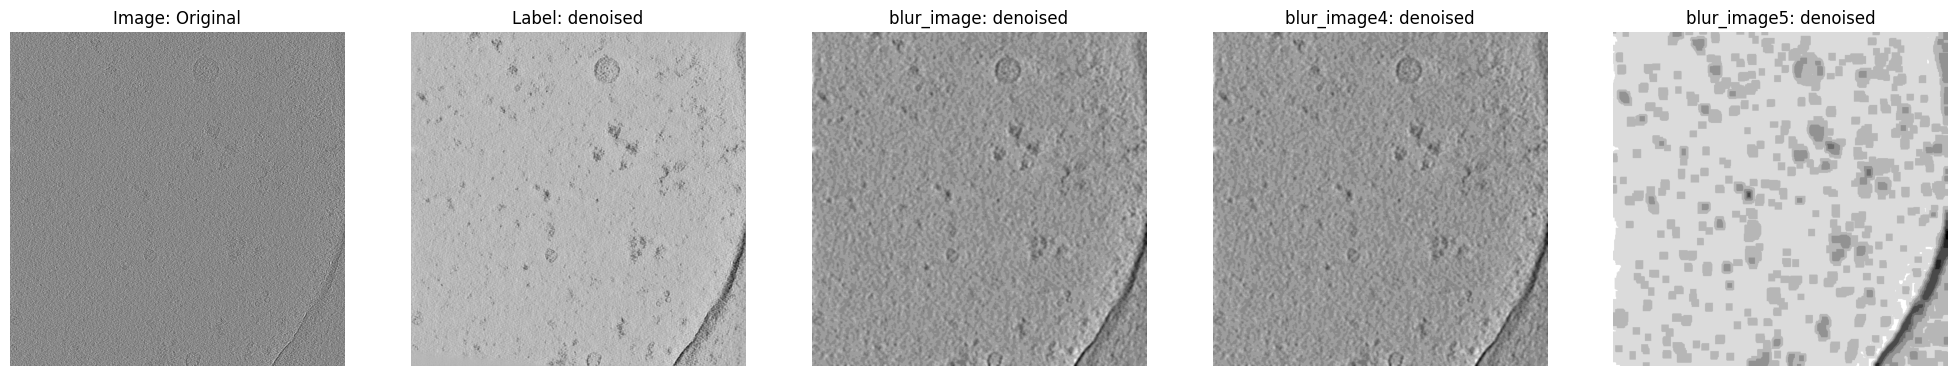

In [6]:
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
import matplotlib.pyplot as plt


slice_idx = 100

image = np.load("./denoised_datasets/train/images/TS_5_4.npy")
blur_image = gaussian_filter(image, sigma=2)
# for i in range(20):
#     blur_image4 = gaussian_filter(blur_image, sigma=1)

blur_image4 = gaussian_filter(image, sigma=2, truncate=5.0)
label = np.load("./denoised_datasets/train/labels/TS_5_4.npy")

blur_image5 = gaussian_filter(blur_image4, sigma=2, truncate=5.0)
blur_image5 = gaussian_filter(blur_image5, sigma=1, truncate=3.0)
blur_image5 = gaussian_filter(blur_image5, sigma=0.5, truncate=3.0)


image = (image - image.min()) / (image.max() - image.min()) * 255
label = (label - label.min()) / (label.max() - label.min()) * 255
image = image.astype(np.uint8)
label = label.astype(np.uint8)

print("unique values in denoised image:", len(np.unique(label)))
print("unique values in wbp image:", len(np.unique(image)))
print("unique values in gaussian blur_image:", len(np.unique(blur_image)))
print("unique values in multi gaussian blur_image4:", len(np.unique(blur_image4)))

print("Original image min:", image.min(), "max:", image.max())
print("Label image min:", label.min(), "max:", label.max())
print("Gaussian blur image min:", blur_image.min(), "max:", blur_image.max())
print("Multi Gaussian blur image min:", blur_image4.min(), "max:", blur_image4.max())

# blur_image = (blur_image - blur_image.min()) / (blur_image.max() - blur_image.min()) * 255
# blur_image = blur_image.astype(np.uint8)

# blur_image4 = (blur_image4 - blur_image4.min()) / (blur_image4.max() - blur_image4.min()) * 255
# blur_image4 = blur_image4.astype(np.uint8)

# blur_image5 = (blur_image5 - blur_image5.min()) / (blur_image5.max() - blur_image5.min()) * 255
# blur_image5 = blur_image5.astype(np.uint8)

# n = 1.2
# blur_image5 = cv2.convertScaleAbs(blur_image, alpha=n, beta=0)

# Apply Low Pass Filter (LPF) to blur_image

print("Original image min:", image.min(), "max:", image.max())
print("Label image min:", label.min(), "max:", label.max())
print("Gaussian blur image min:", blur_image.min(), "max:", blur_image.max())
print("Multi Gaussian blur image min:", blur_image4.min(), "max:", blur_image4.max())
print("unique values in gaussian blur_image:", len(np.unique(blur_image)))
print("unique values in multi gaussian blur_image4:", len(np.unique(blur_image4)))
print("unique values in multi gaussian blur_image5:", len(np.unique(blur_image5)))



plt.figure(figsize=(25, 5))

image=image[slice_idx]
label=label[slice_idx]
blur_image=blur_image[slice_idx]
blur_image4=blur_image4[slice_idx]
blur_image5=blur_image5[slice_idx]

print(f"Mean of image: {image.mean()}, Standard Deviation of image: {image.std()}")
print(f"Mean of label: {label.mean()}, Standard Deviation of label: {label.std()}")
print(f"Mean of blur_image: {blur_image.mean()}, Standard Deviation of blur_image: {blur_image.std()}")
print(f"Mean of blur_image4: {blur_image4.mean()}, Standard Deviation of blur_image4: {blur_image4.std()}")
print(f"Mean of blur_image5: {blur_image5.mean()}, Standard Deviation of blur_image5: {blur_image5.std()}")

# Image 1 비교
plt.subplot(1, 5, 1)
plt.imshow(image, cmap="gray")
plt.title("Image: Original")
plt.axis("off")

plt.subplot(1, 5, 2)
plt.imshow(label, cmap="gray")
plt.title("Label: denoised")
plt.axis("off")

plt.subplot(1, 5, 3)
plt.imshow(blur_image, cmap="gray")
plt.title("blur_image: denoised")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(blur_image4, cmap="gray")
plt.title("blur_image4: denoised")
plt.axis("off")

plt.subplot(1, 5, 5)
plt.imshow(blur_image5, cmap="gray")
plt.title("blur_image5: denoised")
plt.axis("off")


In [ ]:
if

SyntaxError: invalid syntax (4110802630.py, line 1)

## 10441 추가 데이터셋 처리

In [ ]:
# Make a copick project
import os
import shutil
import monai

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/train/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
output_overlay = "./kaggle/working/overlay"


with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
# Update the overlay
# Define source and destination directories
source_dir = './kaggle/input/czii-cryo-et-object-identification/train/overlay'
destination_dir = './kaggle/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

## Test Set 시각화 코드

In [ ]:
# Make a copick project
import os
import shutil
from pathlib import Path

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/test/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
output_overlay = "./kaggle/working/overlay"


with open(copick_config_path, "w") as f:
    f.write(config_blob)
    
import copick
import numpy as np
from tqdm import tqdm

root = copick.from_file(copick_config_path)
print(len(root.runs))

run = root.runs[0]
print(run.name)
tomo = run.get_voxel_spacing(10).get_tomogram("denoised").numpy()
tomo.shape

7
TS_5_4


(184, 630, 630)

In [ ]:

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type_list = ["denoised"]
task_dir = Path('./datasets/task/images')
for dir_path in [task_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

for tomo_type in tomo_type_list:
    print(f"Processing \"{tomo_type}\" data...")
    for run in root.runs:
        # Load image and label data
        tomogram = run.get_voxel_spacing(voxel_size).get_tomogram(tomo_type).numpy()

        # Format run name
        run_name = run.name.replace("\\", "_").replace("/", "_")

        # Save tomogram as numpy array
        image_path = task_dir / f"{tomo_type}_{run_name}_image.npy"
        np.save(image_path, tomogram)

        # 저장된 파일 경로 출력
        print(f"Saved image: {image_path}")
print("Processing complete.")


Processing "denoised" data...
Saved image: datasets\task\images\denoised_TS_5_4_image.npy
Saved image: datasets\task\images\denoised_TS_69_2_image.npy
Saved image: datasets\task\images\denoised_TS_6_4_image.npy


AttributeError: 'NoneType' object has no attribute 'get_tomogram'